# OCS Qubit

## To Do:

1. Create Metal GUI structure for OCS qubit
2. Scattering Simulation of OCS structure
3. Calculate $w_{01}, E_j$ and $E_c$ from simulation
4. Calculate anharmonicity $\alpha$ from `qiskit-metal/hamiltonian/transmon_analytics.py`

## To Set Up:

1. Parameter sweep of OCS qubit to get required $\frac{E_j}{E_c} \approx 20$

In [1]:
from qiskit_metal.qlibrary.qubits.transmon_cross import TransmonCross

D:\Users\lfl\Anaconda3\envs\qiskit-metal\lib\site-packages\pyproj\__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
design = designs.DesignPlanar()
gui = MetalGUI(design)

design._chips['main']['size']['size_x'] = '5mm'
design._chips['main']['size']['size_y'] = '5mm'

design.variables['cpw_width'] = '10 um'
design.variables['cpw_gap'] = '6 um'

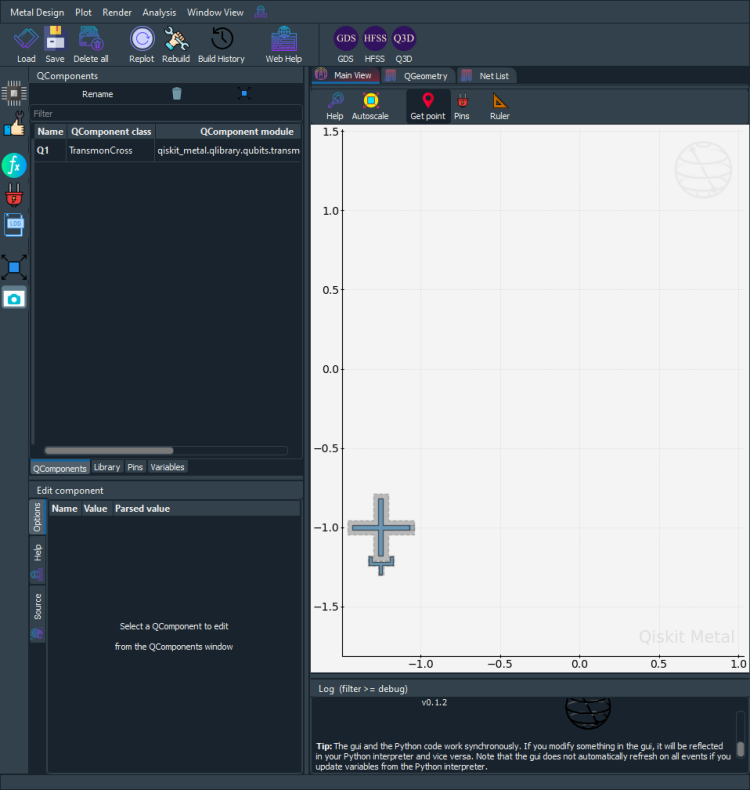

In [3]:
#Allow running the same cell here multiple times to overwrite changes
design.overwrite_enabled = True

########## OCS QUBUIT ########
options_d = dict(
    cross_width = '30um',
    cross_length = '180um',
    cross_gap = '30um',
    chip='main',
    connection_pads=dict(
        ground_pin  = dict(connector_location = '0', connector_type = '0', claw_width = '19.1um', claw_length = '35.9um', ground_spacing = '5um')
    )
)

q_d = TransmonCross(design, 'Q1', options = dict(
    pos_x='-1250um', pos_y='-1mm', orientation = '90', **options_d))

######### REBUILD ##########

gui.rebuild()
gui.autoscale()
gui.screenshot()

In [4]:
# This class lets us get S Y Z parameters
from qiskit_metal.analyses.simulation import ScatteringImpedanceSim
em1 = ScatteringImpedanceSim(design, "hfss")


In [5]:
em1.run()

INFO 11:05PM [connect_project]: Connecting to Ansys Desktop API...
INFO 11:05PM [load_ansys_project]: 	Opened Ansys App
INFO 11:05PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 11:05PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/Users/lfl/Documents/HFSS/
	Project:   Project39
INFO 11:05PM [connect_design]: 	Opened active design
	Design:    ocs_test [Solution type: DrivenModal]
INFO 11:05PM [get_setup]: 	Opened setup `Setup1`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 11:05PM [connect]: 	Connected to project "Project39" and design "ocs_test" 😀 

INFO 11:05PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 11:05PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 11:05PM [analyze]: Analyzing setup Setup : Sweep


In [6]:
resistance = 50 #Ohms (Signal Path Resistance)

In [7]:
hfss = em1.renderer

hfss.activate_ansys_design("ocs_test", 'drivenmodal')

# Render Model
hfss.clean_active_design()

hfss.max_mesh_length_port = '0.01um'
hfss.max_mesh_length_jj = '0.015um'

hfss.render_design(selection=['Q1'], 
                   open_pins = [], 
                   port_list = [('Q1', 'ground_pin', resistance)],
                   box_plus_buffer = True)

INFO 11:06PM [connect_design]: 	Opened active design
	Design:    ocs_test [Solution type: DrivenModal]


In [8]:
hfss.pinfo

In [9]:
em1.setup.sweep_setup.start_ghz = 2
em1.setup.sweep_setup.stop_ghz = 20

# Change Simulation Settings
em1.setup.reuse_selected_design = False
em1.setup.reuse_setup = False
em1.setup.max_passes = 12
em1.setup.min_passes = 5
em1.setup.max_delta_s = 0.1
em1.setup.min_converged = 5
em1.setup.pct_refinement = 30
em1.setup.sweep_setup.count = 25000
em1.setup.sweep_setup.type = 'Interpolating'
# example: update multiple settings

em1.setup.vars.Lj = '10 nH'
em1.setup.vars.Cj = '4.02 fF'

em1.setup.junctions.jj.rect = 'JJ_rect_Lj_diss_rect_jj'
em1.setup.junctions.jj.line = 'JJ_Lj_diss_rect_jj_'

em1.setup


{'name': 'Setup',
 'reuse_selected_design': False,
 'reuse_setup': False,
 'freq_ghz': 5,
 'max_delta_s': 0.1,
 'max_passes': 12,
 'min_passes': 5,
 'min_converged': 5,
 'pct_refinement': 30,
 'basis_order': 1,
 'vars': {'Lj': '10 nH', 'Cj': '4.02 fF'},
 'sweep_setup': {'name': 'Sweep',
  'start_ghz': 2,
  'stop_ghz': 20,
  'count': 25000,
  'step_ghz': None,
  'type': 'Interpolating',
  'save_fields': False},
 'junctions': {'jj': {'rect': 'JJ_rect_Lj_diss_rect_jj',
   'line': 'JJ_Lj_diss_rect_jj_'}}}

In [10]:
em1._analyze()

INFO 11:06PM [get_setup]: 	Opened setup `Setup3`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 11:06PM [get_setup]: 	Opened setup `Setup3`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 11:06PM [analyze]: Analyzing setup Setup3 : Sweep


In [11]:
%matplotlib inline

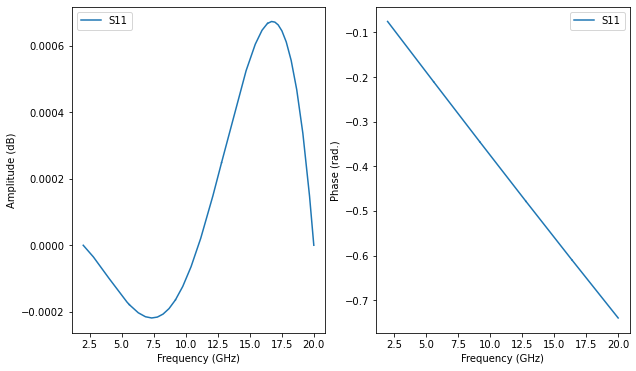

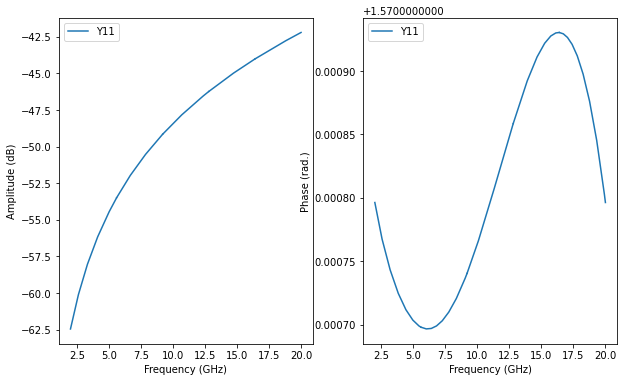

In [12]:
dataframe_scattering = em1.get_scattering(['S11'])
dataframe_admittance = em1.get_admittance(['Y11'])

df_s = dataframe_scattering[0]
df_y = dataframe_admittance[0]


def get_real_and_imag(a_ii):
    return a_ii.values.real, a_ii.values.imag

s11real, s11imag = get_real_and_imag(df_s['S11'])
y11real, y11imag = get_real_and_imag(df_y['Y11'])


dataframe_scattering[0]['Real(S11)'] = s11real
dataframe_scattering[0]['Imag(S11)'] = s11imag
dataframe_admittance[0]['Real(Y11)'] = y11real
dataframe_admittance[0]['Imag(Y11)'] = y11imag

In [13]:
import matplotlib.pyplot as plt

  magnitude.show()



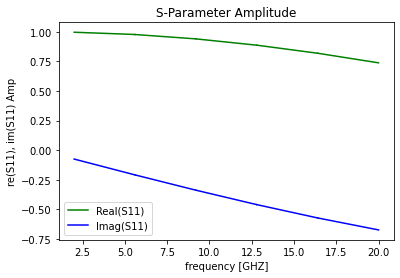

In [14]:
# Reference to current axis.
magnitude = plt.figure('Real S11, Imag S21')
axis = plt.gca() # Get current axis.
dataframe_scattering[0].plot(kind = 'line', y='Real(S11)', color = 'green', ax = axis)
dataframe_scattering[0].plot(kind = 'line', y='Imag(S11)', color = 'blue', ax = axis)
plt.title(f'S-Parameter Amplitude')
plt.xlabel(f'frequency [GHZ]')
plt.ylabel(f're(S11), im(S11) Amp')
magnitude.show()

# Resonator Profiling:

In [17]:
import sys
import numpy as np
import pyEPR.calcs
from pyEPR.calcs import Convert

sys.path.append(r'C:/Users/lfl/fitTools/')

In [19]:
from fitTools.Resonator import *

In [20]:
reals11 = dataframe_scattering[0]['Real(S11)']
imags11 = dataframe_scattering[0]['Imag(S11)']
freqs = np.array(list(reals11.keys())) * 1e9
I = np.array(list(reals11.values))
Q = np.array(list(imags11.values))

In [21]:
res = Resonator(f_data=freqs,z_data=I + 1j*Q)

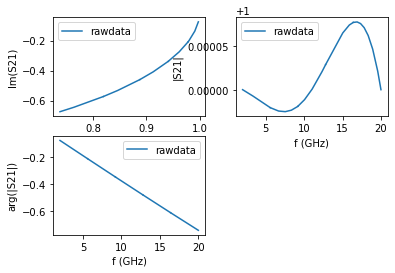

In [33]:
res.plotrawdata()

In [32]:
res.autofit()

fit error = [4.23016137e-05 7.72523734e-01 6.56477359e+03]
The fit could not be found, try cropping the data with autofit(fcrop=(f1 [GHz],f2 [GHz]))


In [24]:
res.show()

AttributeError: 'Resonator' object has no attribute 'z_data_sim'

In [34]:
def cal_Ec_from_freq(freq,Lj):
    omega = freq * 2*np.pi * 1e9
    e = 1.60217663e-19 # in coulombs
    C = 1/(Lj * 1e-9 * omega ** 2)
    h = 6.62607015 *  1e-34
    Ec = e ** 2/2/C/h/1e6 # in MHz, linear freq
    print(f'Ec = {Ec:.0f} MHz')
    return Ec

def cal_g_in_linear_freq(res,Lj, w_c = 6.2e9):
    # Lj in nH
    kappa = res.kappa
    Z_0 = 50
    omega_0 = res.f0 * 2 * np.pi
    Lj = Lj*1e-9
    e = 1.60217663e-19 # in coulombs
    hbar = 1.05457182e-34 # in m^2*kg/s
    C_c = np.sqrt(kappa / (Lj*Z_0)) * (1/omega_0**2)
    g = C_c/(1/(Lj * omega_0**2)) * np.sqrt(Z_0*e**2/(np.pi*hbar)) *w_c/1e6
    print(f'g/2pi = {g:.1f} MHz')
    return g


def cal_gamma_in_linear_freq(res):
    gamma = res.f0/res.Qi/1e6
    print(f'gamma/2pi = {gamma:.1f} MHz')
    return gamma

def print_design_parameters(options):
    keys1 = ['cross_width','cross_length','cross_gap']
    keys2 = ['finger_count','finger_length','cap_gap','cap_gap_ground','cap_width']
    keys3 = ['termination_finger_count', 'termination_finger_length','termination_cap_gap','termination_cap_gap_ground','termination_cap_width']
    keys4 = ['hfss_inductance']
    params = [key + ' = ' + "'"+ str(value) + "'" for key,value in options.items() if key in keys1 + keys2 +keys3 + keys4] 
    print(',\n'.join(params)+',')
    
def print_simulated_results(res, Lj):
    print(f'f = {res.f0/1e9:.2f} GHz')
    cal_Ec_from_freq(res.f0/1e9,Lj)
    cal_g_in_linear_freq(res,Lj)
    cal_gamma_in_linear_freq(res) 

In [41]:
Lj = float(q_d.options['hfss_inductance'][:-2])
Ej = Convert.Ej_from_Lj(Lj, 'nH', "GHz")
Ec = cal_Ec_from_freq(res.f0/1e9,Lj)

print(f"Ej = {Ej} GHz")
print_simulated_results(res,Lj)
print(f"\nEj/Ec = {Ej/Ec}")


Ec = nan MHz
Ej = 16.34615128067812 GHz
f = nan GHz
Ec = nan MHz
g/2pi = nan MHz
gamma/2pi = nan MHz

Ej/Ec = nan


In [36]:
print_design_parameters(q_d.options)

cross_width = '30um',
cross_length = '180um',
cross_gap = '30um',
hfss_inductance = '10nH',


In [54]:
# define the Josephson to charging energy ratio E_J / E_C
RATIO = 1

# define the charing energy
E_C = 1

In [55]:
from scipy.special import mathieu_a
import numpy as np
import matplotlib.pyplot as plt

__all__ = ['kidx_raw', 'kidx', 'transmon_eigenvalue', 'plot_eigenvalues']


def kidx_raw(m, my_ng):
    """
    This function calculates the integers which correct sort the eigenstates and eigenenergies
    of the solution to Mathieu's equation.

        Args:
            m (int): The energy level of the qubit (m=0,1,2,3,etc.)
            my_ng (float): the offset charge of the Josephjunction island (in units of 2e)

        Returns:
            float: the calculated index
    """
    if my_ng == 0:
        return m + 1.0 - ((m + 1.0) % 2.0)

    return m + 1.0 - ((m + 1.0) % 2.0) + 2.0 * my_ng * (
        (-1.0)**(m - 0.5 * (np.sign(my_ng) - 1.0)))


def kidx(m, my_ng):
    """
    This function is a placeholder which performs an additional modulo operation
    with an offset of ng=0.5, but is not necessary when only integer values of
    kidxRAW(m, my_ng) are used. If non-integer values of kidxRAW are used, then
    the modulo operation below needs to be updated to include the offset.

        Args:
            m (int): The energy level of the qubit (m=0,1,2,3,etc.)
            ng (float): the offset charge of the Josephjunction island (in units of 2e)

        Returns:
            float: the calculated energy eigenvalue, after an ng=0.5 offset.
    """
    return kidx_raw(m, my_ng)


def transmon_eigenvalue(m, my_ng):
    """
    This function calculate the energy eigenvalue of the transmon qubit for a given
    energy level (m) and offset charge (my_ng). The input values are first used to
    calculate the index using the function defined above, and then the calculated
    index is used to calculate the energy eigenvalue using Mathieu's characteristic values.

        Args:
            m (int): The energy level of the qubit (m=0,1,2,3,etc.)
            ng (float): the offset charge of the Josephjunction island (in units of 2e)

        Returns:
            float: the calculated energy eigenvalue.
    """
    index = kidx(m, my_ng)
    return (E_C) * mathieu_a(index, -0.5 * RATIO)


# extremely coarse grid: only three points from -0.5 to 0.5. This so that only integer values
# of the index are used in the calculation of the Mathieu characteristic value.
ng = np.linspace(-0.5, 0.5, 3)

# ng is periodic extending from -2 to 2:
ng_periodic = np.linspace(-2.0, 2.0, 9)

# define energies between (-0.5, 0.5) as empty lists.
E0 = []
E1 = []
E2 = []
E3 = []

# define periodic energies between (-2.0, 2.0)
E0_periodic = [None] * 9
E1_periodic = [None] * 9
E2_periodic = [None] * 9
E3_periodic = [None] * 9

# calculate the energies for m=0,1,2 at each value of offset charge
for i in ng:
    E0.append(transmon_eigenvalue(0, i))
    E1.append(transmon_eigenvalue(1, i))
    E2.append(transmon_eigenvalue(2, i))
    E3.append(transmon_eigenvalue(3, i))

# define the periodic eigen energies based on the values between (-0.5,0.5)
for i in range(len(E0_periodic)):
    E0_periodic[0] = E0[1]
    E0_periodic[1] = E0[0]
    E1_periodic[0] = E1[1]
    E1_periodic[1] = E1[0]
    E2_periodic[0] = E2[1]
    E2_periodic[1] = E2[0]
    E3_periodic[0] = E3[1]
    E3_periodic[1] = E3[0]

    if i > 1:
        E0_periodic[i] = E0_periodic[i - 2]
        E1_periodic[i] = E1_periodic[i - 2]
        E2_periodic[i] = E2_periodic[i - 2]
        E3_periodic[i] = E3_periodic[i - 2]


def plot_eigenvalues():
    """
    This function actually creates the plot(s) of eigenvalues as a function of
    offset charge. No arguments need to be passed.

    Returns:
        A plot of the eigenvalues as a function of offset charge.
    """
    # plot the PERIODIC eigen energies between (-2.0, 2.0)
    plt.plot(ng_periodic, E0_periodic, 'k')  # m=0
    plt.plot(ng_periodic, E1_periodic, 'r')  # m=1
    plt.plot(ng_periodic, E2_periodic, 'b')  # m=2
    plt.plot(ng_periodic, E3_periodic, 'm')  # m=3
    plt.xlabel("Offset Charge [ng]")
    plt.ylabel("Energy E_m[ng]")

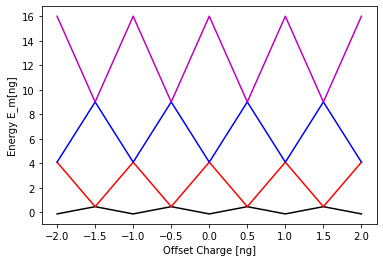

In [56]:
plot_eigenvalues()

In [58]:
alpha = transmon_eigenvalue(2, 0) - 2*transmon_eigenvalue(0, 0)  
alpha

4.344431685442646